In [1]:
import os
import sys
from os.path import join
import pandas as pd
import numpy as np
import time
import itertools

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# stats on collaboration as functions of location and distance

In [3]:
collab_df = pd.read_table('data/processed/collaborations.tsv', sep='\t')

In [4]:
collab_df.head()

,PUBLICATION_ID,PUBLICATION_TYPE,PUBLICATION_URI,PUBLISHED_DATE,TOTAL_AUTHORS,dst_DUID,dst_FIRST_NAME,dst_LAST_NAME,dst_MIDDLE_NAME,src_DUID,...,src_LAT,dst_ADDRESS,dst_CITY,dst_ZIP,dst_LON,dst_LAT,distance,duration,transportMode,crowDistance
0,0,Journal Article,https://scholars.duke.edu/individual/pub1000033,5/1/2013 12:00:00 AM,2,272070,Shelby,Reed,Derene,99016,...,36.003337,40 Duke Medicine Cir,DURHAM,27705,-78.935915,36.003337,0.0,0.0,walk,0.000000
1,1,Journal Article,https://scholars.duke.edu/individual/pub1000035,7/1/2013 12:00:00 AM,2,591120,John,Reynolds,Michael,119821,...,36.003337,40 Duke Medicine Cir,DURHAM,27705,-78.935915,36.003337,0.0,0.0,walk,0.000000
2,2,Journal Article,https://scholars.duke.edu/individual/pub1000091,10/3/2012 12:00:00 AM,2,98973,John,Alexander,Hunter Peel,314783,...,36.003337,40 Duke Medicine Cir,DURHAM,27705,-78.935915,36.003337,0.0,0.0,walk,0.000000
3,3,Journal Article,https://scholars.duke.edu/individual/pub1000099,11/1/2013 12:00:00 AM,2,449347,Endi,Wang,NaN,435364,...,36.003063,40 Duke Medicine Cir,DURHAM,27705,-78.936950,36.003063,0.0,0.0,walk,0.000000
4,4,Journal Article,https://scholars.duke.edu/individual/pub1000158,1/1/2013 12:00:00 AM,3,135843,Evan,Myers,Robert,373496,...,36.007164,40 Duke Medicine Cir,DURHAM,27705,-78.935105,36.003996,1110.0,883.0,walk,618.435335


In [5]:
collab_df.columns

Index([u'PUBLICATION_ID', u'PUBLICATION_TYPE', u'PUBLICATION_URI',
       u'PUBLISHED_DATE', u'TOTAL_AUTHORS', u'dst_DUID', u'dst_FIRST_NAME',
       u'dst_LAST_NAME', u'dst_MIDDLE_NAME', u'src_DUID', u'src_FIRST_NAME',
       u'src_LAST_NAME', u'src_MIDDLE_NAME', u'src_OrgBFR', u'dst_OrgBFR',
       u'src_DUKE_NUMBER', u'dst_DUKE_NUMBER', u'src_BL_ID', u'dst_BL_ID',
       u'src_ADDRESS', u'src_CITY', u'src_ZIP', u'src_LON', u'src_LAT',
       u'dst_ADDRESS', u'dst_CITY', u'dst_ZIP', u'dst_LON', u'dst_LAT',
       u'distance', u'duration', u'transportMode', u'crowDistance'],
      dtype='object')

### build table of each unique combination of two people
mark a binary response (1 or 0) of whether they collaborated together or not, and what the distance between them is

In [6]:
srcAuthors = np.unique(collab_df.src_DUID)
dstAuthors = np.unique(collab_df.dst_DUID)

# unique list of all Authors in the table
allAuthors = np.unique(np.concatenate([srcAuthors, dstAuthors], axis=0))

In [7]:
# start columns for each unique author pair
authorDict = {'a1': [], 'a2':[]}
for a1, a2 in itertools.combinations(allAuthors, 2):
    authorDict['a1'].append(a1)
    authorDict['a2'].append(a2)
    
# write to dataframe
author_df = pd.DataFrame.from_dict(authorDict)

In [8]:
author_df.head()

,a1,a2
0,1080,2361
1,1080,3478
2,1080,4700
3,1080,5212
4,1080,5545


Read in tables with additional information about distances and durations between buildings

In [42]:
b2b_distance = pd.read_table('data/processed/bldg2bldg_distance.tsv', sep='\t', index_col=0)
b2b_duration = pd.read_table('data/processed/bldg2bldf_duration.tsv', sep='\t', index_col=0)

In [43]:
b2b_duration.head()

,7201,7202,7224,7251,7261,7501,7506,7507,7508,7512,...,7760,7765,7776,8084,8116,8141,8166,8239,8304,8329
7201,0.0,82.0,80.0,497.0,417.0,442.0,442.0,442.0,442.0,348.0,...,660.0,504.0,583.0,870.0,946.0,473.0,354.0,541.0,709.0,790.0
7202,82.0,0.0,109.0,459.0,430.0,428.0,428.0,428.0,428.0,334.0,...,609.0,456.0,569.0,883.0,864.0,459.0,340.0,432.0,627.0,772.0
7224,80.0,109.0,0.0,417.0,469.0,460.0,460.0,460.0,460.0,366.0,...,677.0,565.0,601.0,922.0,976.0,491.0,372.0,537.0,635.0,863.0
7251,497.0,459.0,417.0,0.0,870.0,445.0,445.0,445.0,445.0,351.0,...,647.0,567.0,586.0,303.0,1000.0,451.0,295.0,464.0,592.0,791.0
7261,417.0,430.0,469.0,870.0,0.0,413.0,413.0,413.0,413.0,319.0,...,557.0,425.0,554.0,623.0,1127.0,444.0,1113.0,361.0,941.0,675.0


In [76]:
def findBuilding(duid):
    # find the building associated with a given DUID
    
    # start by looking in the src author column
    if duid in collab_df.src_DUID.values:
        bl_id = collab_df.loc[collab_df.src_DUID == duid, 'src_BL_ID'].iloc[0]
    
    # otherwise check the dst author column
    elif duid in collab_df.dst_DUID.values:
        bl_id = collab_df.loc[collab_df.dst_DUID == duid, 'dst_BL_ID'].iloc[0]
    else:
        bl_id = 666
    return bl_id

def totalCollabs(row):
    # calculate the number of times and two authors collaborated together
    a1 = row['a1']
    a2 = row['a2']
    
    # check for instance where a1=src and a2=dst, and the opposite
    src2dst_collabs = collab_df.loc[(collab_df.src_DUID == a1) & (collab_df.dst_DUID == a2)]
    dst2src_collabs = collab_df.loc[(collab_df.dst_DUID == a1) & (collab_df.src_DUID == a2)]
    
    # add the two together
    totalCollabs = src2dst_collabs.shape[0] + dst2src_collabs.shape[0]
    
    return totalCollabs

def didTheyCollaborate(totalCollabs):
    # boolean response about whether 2 authors collaborated at all
    if totalCollabs > 0:
        wellDidThey = 1
    else:
        wellDidThey = 0
    return wellDidThey


# Following functions must be run AFTER findBuilding on both a1 and a2
def getDistance(row):
    # get the distance between the 2 buildings
    b1 = int(row['a1_BL_ID'])
    b2 = int(row['a2_BL_ID'])
    
    dist = b2b_distance.loc[b1, str(b2)]  # note: index labels are int64, columns are string objects
    return dist

def getDuration(row):
    # get the travel duration between the 2 buildings
    b1 = int(row['a1_BL_ID'])
    b2 = int(row['a2_BL_ID'])
    
    dur = b2b_duration.loc[int(b1), str(b2)]  # note: index labels are int64, columns are string objects
    return dur

Add the additional column to the author df. NOTE: this take a while, so save afterwards

In [28]:
author_df['a1_BL_ID'] = author_df['a1'].apply(findBuilding)
author_df['a2_BL_ID'] = author_df['a2'].apply(findBuilding)
author_df['totalCollabs'] = author_df.apply(totalCollabs, axis=1)
author_df['collaborated'] = author_df['totalCollabs'].apply(didTheyCollaborate)

In [62]:
author_df.to_csv('test.txt', index=False)

In [77]:
#author_df['distance'] = author_df.apply(getDistance, axis=1)
author_df['duration'] = author_df.apply(getDuration, axis=1)

In [79]:
author_df[['distance', 'duration']] = author_df[['distance', 'duration']].astype(int)

In [81]:
author_df.to_csv('data/processed/author2author_collabs.tsv', sep='\t', index=False)

## summarize the results

In [190]:
didCollab = author_df.loc[author_df.collaborated == 1, :]
#didCollab = didCollab[didCollab.distance > 0]

In [191]:
didCollab.to_csv('data/processed/uniqueCollaborations.tsv', sep='\t', index=False)

(0, 10000)

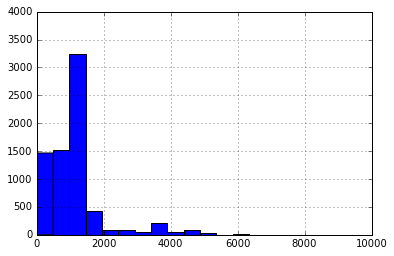

In [98]:
didCollab.distance.hist(bins=50)
plt.gca().set_ylim(0,4000)
plt.gca().set_xlim(0,10000)

(0, 1300)

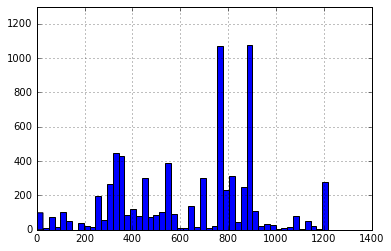

In [99]:
didCollab.duration.hist(bins=50)
plt.gca().set_ylim(0,1300)

### look at proportion of collaborations (out of total possible) at different distance and duration bins

Start by looking at distance

In [101]:
author_df.distance.max()

24376

In [104]:
total_byDistBin = author_df.groupby(pd.cut(author_df['distance'], np.arange(0, 24400, 100))).count()
sum_byDistBin = author_df.groupby(pd.cut(author_df['distance'], np.arange(0, 24400, 100))).sum()

In [130]:
prop_byDistBin = pd.concat([total_byDistBin.collaborated, sum_byDistBin.collaborated], axis=1, join='inner')
prop_byDistBin.columns = ['totalPossible', 'n_collaborations']
prop_byDistBin['prop'] = prop_byDistBin.apply(lambda x: np.true_divide(x.n_collaborations, x.totalPossible), axis=1)

In [132]:
prop_byDistBin.head()

,totalPossible,n_collaborations,prop
distance,,,
"(0, 100]",56608,160.0,0.002826
"(100, 200]",41548,195.0,0.004693
"(200, 300]",25913,80.0,0.003087
"(300, 400]",40359,205.0,0.005079
"(400, 500]",154792,826.0,0.005336


(0, 0.01)

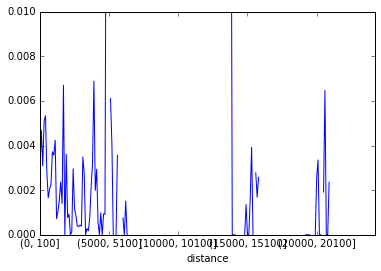

In [137]:
prop_byDistBin.prop.plot()
plt.gca().set_ylim(0, .01)

Now, duration...

In [154]:
total_byDurBin = author_df.groupby(pd.cut(author_df['duration'], np.arange(0, 1280, 30))).count()
sum_byDurBin = author_df.groupby(pd.cut(author_df['duration'], np.arange(0, 1280, 30))).sum()

In [155]:
prop_byDurBin = pd.concat([total_byDurBin.collaborated, sum_byDurBin.collaborated], axis=1, join='inner')
prop_byDurBin.columns = ['totalPossible', 'n_collaborations']
prop_byDurBin['prop'] = prop_byDurBin.apply(lambda x: np.true_divide(x.n_collaborations, x.totalPossible), axis=1)

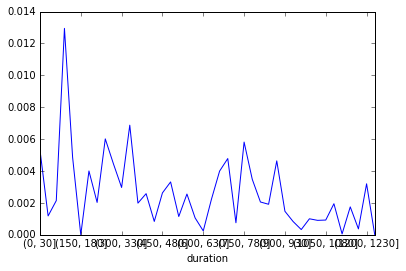

In [156]:
prop_byDurBin.prop.plot()
#plt.gca().set_ylim(0, .01)

In [158]:
prop_byDurBin.head()

,totalPossible,n_collaborations,prop
duration,,,
"(0, 30]",18571,99,0.005331
"(30, 60]",9299,11,0.001183
"(60, 90]",41512,89,0.002144
"(90, 120]",2008,26,0.012948
"(120, 150]",26766,130,0.004857


In [187]:
# fit a curve to the duration data
y = prop_byDurBin.prop.values
x = np.arange(len(y))

fit = np.polyfit(x, y, 2)
p = np.poly1d(fit)


(0, 0.008)

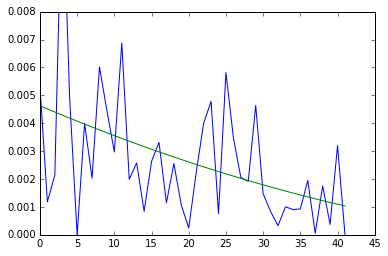

In [189]:
plt.plot(x, y)
plt.plot(x, p(x))
plt.ylim(0,.008)

Duration is interesting. But this is collaping across "walkers" and "drivers". Separate by transporation mode and redo

In [159]:
# separate based on a distance of 1 mile (i.e 1609 m)
walkers = author_df.loc[author_df.distance <= 1609, :]
drivers = author_df.loc[author_df.distance > 1609, :]

In [164]:
walker_total_byDurBin = walkers.groupby(pd.cut(walkers['duration'], np.arange(0, 1280, 30))).count()
walker_sum_byDurBin = walkers.groupby(pd.cut(walkers['duration'], np.arange(0, 1280, 30))).sum()

# combine into new table
walker_propByDur = pd.concat([walker_total_byDurBin.collaborated, walker_sum_byDurBin.collaborated], axis=1, join='inner')
walker_propByDur.columns = ['totalPossible', 'n_collaborations']

# calculate porportion
walker_propByDur['prop'] = walker_propByDur.apply(lambda x: np.true_divide(x.n_collaborations, x.totalPossible), axis=1)

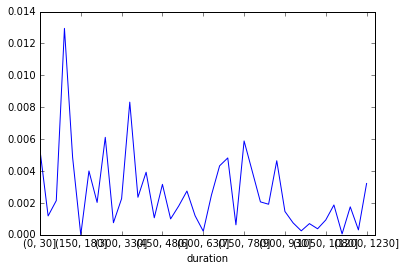

In [165]:
walker_propByDur.prop.plot()

In [166]:
driver_total_byDurBin = drivers.groupby(pd.cut(drivers['duration'], np.arange(0, 1280, 30))).count()
driver_sum_byDurBin = drivers.groupby(pd.cut(drivers['duration'], np.arange(0, 1280, 30))).sum()

# combine into new table
driver_propByDur = pd.concat([driver_total_byDurBin.collaborated, driver_sum_byDurBin.collaborated], axis=1, join='inner')
driver_propByDur.columns = ['totalPossible', 'n_collaborations']

# calculate porportion
driver_propByDur['prop'] = driver_propByDur.apply(lambda x: np.true_divide(x.n_collaborations, x.totalPossible), axis=1)